# Projet Data Mining : Développement d'un Chatbot médical à base de GPT2 en utilisant Pytorch.
## Réalisé par : ASSELLAOU Mouhcine, BOUYAHYAOUI Soufiane et TALHA ELhassane

##### Importation des bibliothèques

In [1]:
!pip install gradio

import pandas as pd
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from collections import Counter
from google.colab import drive
from textblob import TextBlob
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import numpy as np
import json
import torch
import numpy as np
import gradio as gr
import json
import re
import os


##### Importation et nettoyage de la base de données

In [2]:
# Fonction pour nettoyer le texte
def clean_text(text):
    # Vérification si l'entrée est une chaîne de caractères
    if not isinstance(text, str):
        # Gestion des cas où l'entrée n'est pas une chaîne (par exemple, convertir en chaîne ou retourner une chaîne vide/par défaut)
        text = str(text) if text is not None else ''

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Suppression des caractères spéciaux
    text = re.sub(r'\s+', ' ', text).strip()  # Normalisation de l'espace
    return text


# Fonction pour charger et nettoyer les données depuis QA.json
def load_and_clean_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)

    cleaned_data = []
    question_lengths = []
    answer_lengths = []

    for intent in data['intents']:
        if intent['pattern'] and intent['response']:
            question = clean_text(intent['pattern'])
            answer = clean_text(intent['response'])
            cleaned_data.append({'pattern': question, 'response': answer})
            question_lengths.append(len(question.split()))
            answer_lengths.append(len(answer.split()))

    return cleaned_data, question_lengths, answer_lengths


# La base de données
filepath = '/content/QA.json'
cleaned_data, question_lengths, answer_lengths = load_and_clean_data(filepath)




##### Visualisation de la base de données

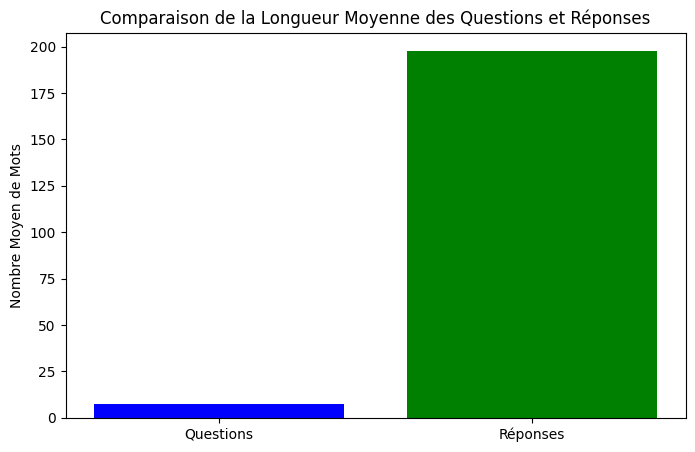

In [3]:
# Calcul des longueurs moyennes
df = pd.DataFrame(cleaned_data)
average_question_length = np.mean([len(q.split()) for q in df['pattern']])
average_answer_length = np.mean([len(a.split()) for a in df['response']])

categories = ['Questions', 'Réponses']
values = [average_question_length, average_answer_length]

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'green'])
plt.title('Comparaison de la Longueur Moyenne des Questions et Réponses')
plt.ylabel('Nombre Moyen de Mots')
plt.show()


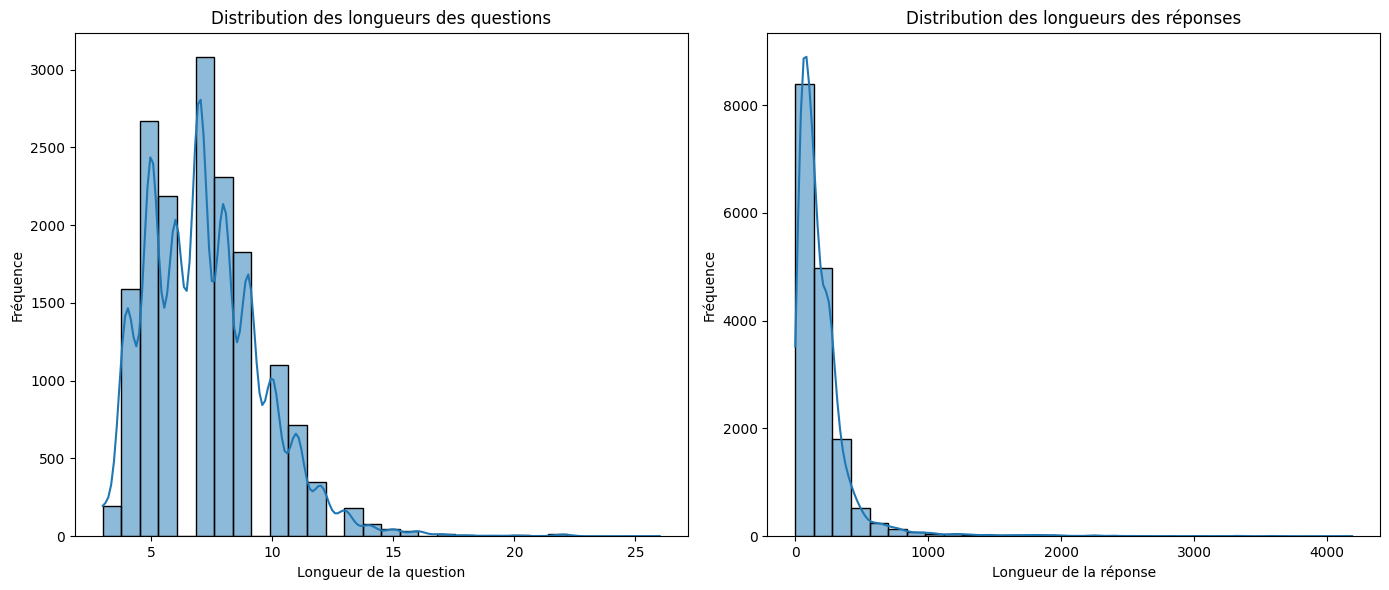

In [4]:
# Visualisation de la distribution des longueurs des questions et réponses
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(question_lengths, bins=30, kde=True)
plt.title('Distribution des longueurs des questions')
plt.xlabel('Longueur de la question')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
sns.histplot(answer_lengths, bins=30, kde=True)
plt.title('Distribution des longueurs des réponses')
plt.xlabel('Longueur de la réponse')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

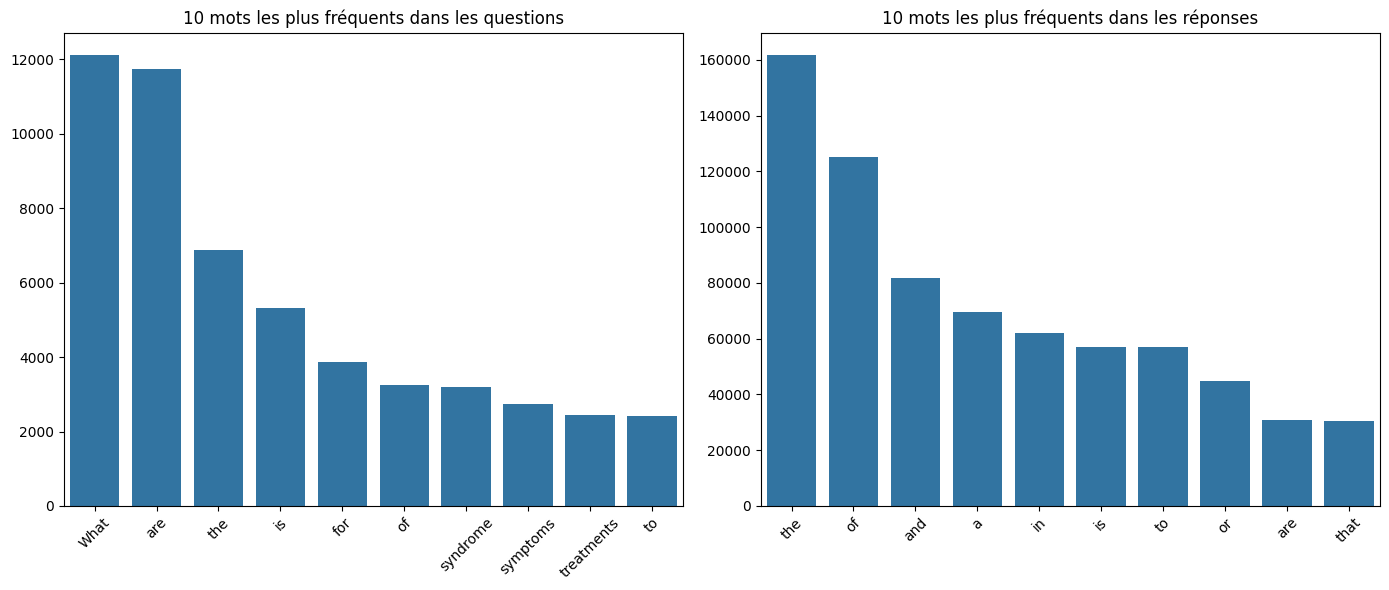

In [5]:
# Calcul de la fréquence des mots dans les questions et les réponses
word_counts_questions = Counter(word for question in cleaned_data for word in question['pattern'].split())
word_counts_answers = Counter(word for answer in cleaned_data for word in answer['response'].split())

# Affichage des 10 mots les plus fréquents dans les questions
most_common_words_questions = word_counts_questions.most_common(10)
words_questions, counts_questions = zip(*most_common_words_questions)

# Affichage des 10 mots les plus fréquents dans les réponses
most_common_words_answers = word_counts_answers.most_common(10)
words_answers, counts_answers = zip(*most_common_words_answers)

# Création des graphiques
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=list(words_questions), y=list(counts_questions))
plt.title('10 mots les plus fréquents dans les questions')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=list(words_answers), y=list(counts_answers))
plt.title('10 mots les plus fréquents dans les réponses')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


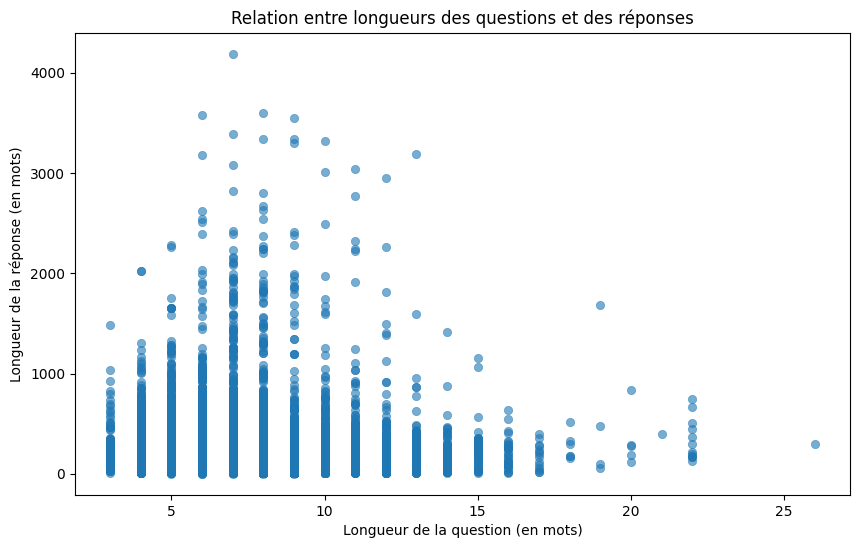

Coefficient de corrélation: 0.04


In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=question_lengths, y=answer_lengths, alpha=0.6, edgecolor=None)
plt.title('Relation entre longueurs des questions et des réponses')
plt.xlabel('Longueur de la question (en mots)')
plt.ylabel('Longueur de la réponse (en mots)')
plt.show()

#calcul d'un coefficient de corrélation
correlation_coefficient = np.corrcoef(question_lengths, answer_lengths)[0, 1]
print(f"Coefficient de corrélation: {correlation_coefficient:.2f}")


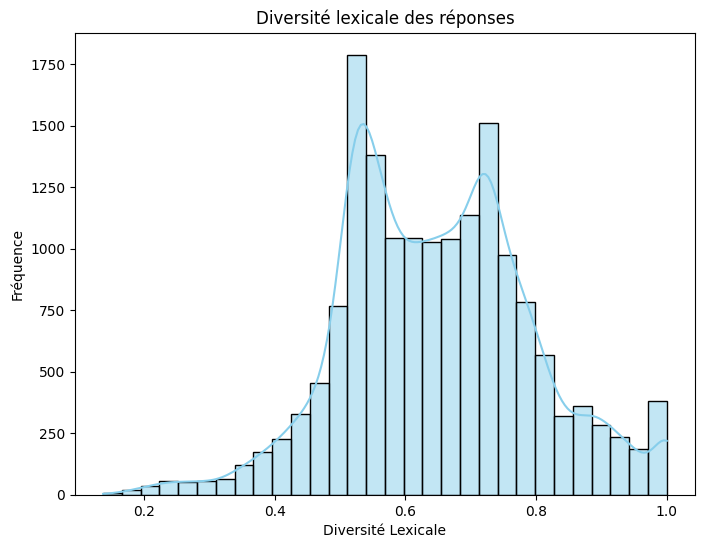

In [7]:
# Calcul de la diversité lexicale pour un texte donné
def calculate_lexical_diversity(text):
    tokens = text.split()
    total_tokens = len(tokens)
    unique_tokens = len(set(tokens))
    return unique_tokens / total_tokens if total_tokens > 0 else 0


# Application du calcul de la diversité lexicale sur l'ensemble des réponses
df['lexical_diversity'] = df['response'].apply(calculate_lexical_diversity)

# Visualisation de la diversité lexicale des réponses
plt.figure(figsize=(8, 6))
sns.histplot(df['lexical_diversity'], bins=30, kde=True, color='skyblue')
plt.title('Diversité lexicale des réponses')
plt.xlabel('Diversité Lexicale')
plt.ylabel('Fréquence')
plt.show()



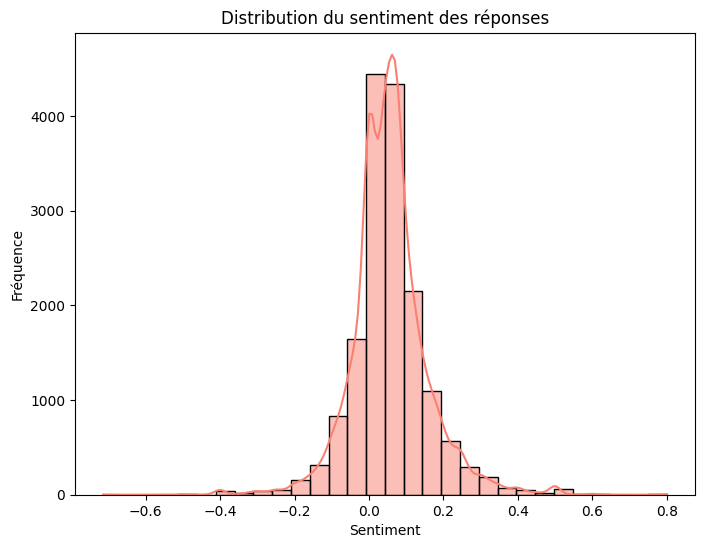

In [8]:
# Calcul du sentiment pour un texte donné
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # La polarité varie de -1 (négatif) à 1 (positif)

# Application du calcul de sentiment sur l'ensemble des réponses
df['sentiment'] = df['response'].apply(calculate_sentiment)

# Visualisation de la distribution des sentiments des réponses
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment'], bins=30, kde=True, color='salmon')
plt.title('Distribution du sentiment des réponses')
plt.xlabel('Sentiment')
plt.ylabel('Fréquence')
plt.show()



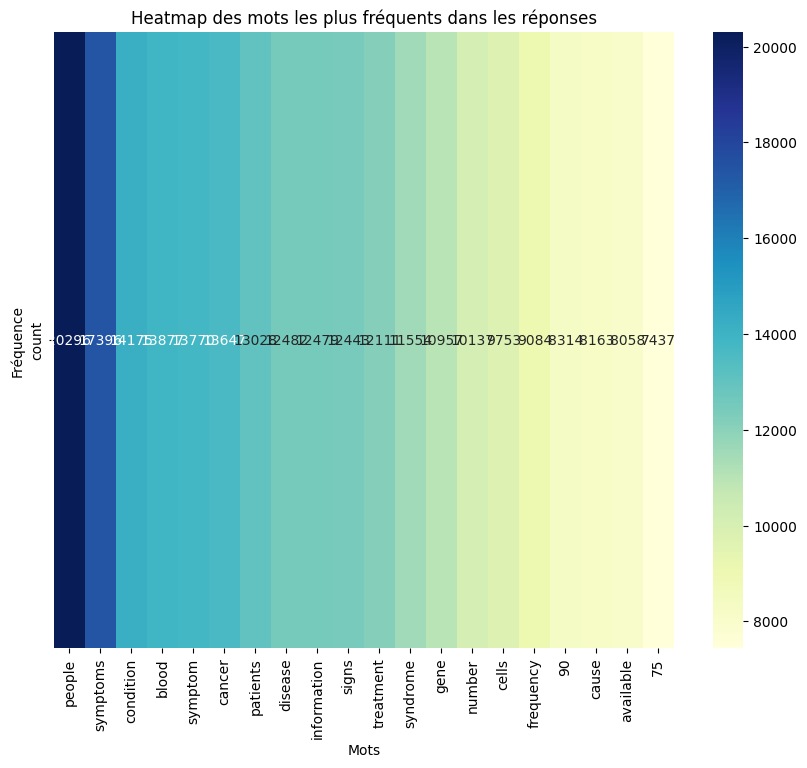

In [9]:
# Fréquence des mots dans les réponses
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['response'])
word_counts = np.sum(X.toarray(), axis=0)
words = vectorizer.get_feature_names_out()

# Création d'un DataFrame pour les visualisations
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts})
top_words = word_freq_df.nlargest(20, 'count')

# Création du heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=top_words.set_index('word').T, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Heatmap des mots les plus fréquents dans les réponses')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.show()


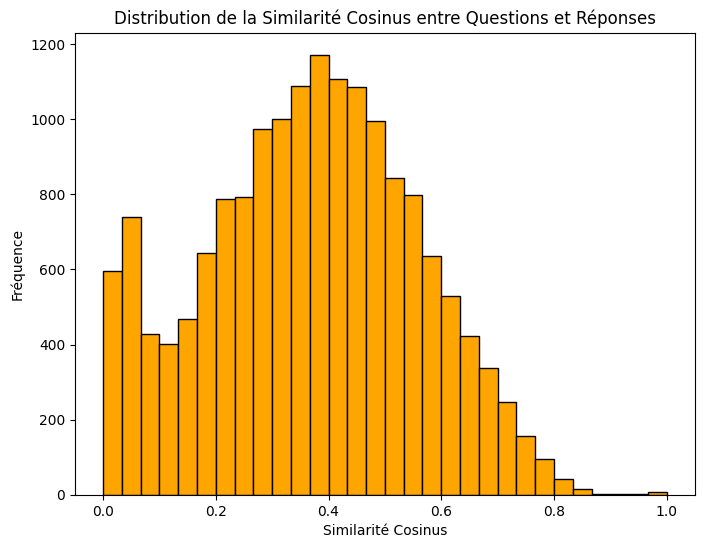

In [10]:
text_data = pd.concat([df['pattern'], df['response']]).reset_index(drop=True)

# Génération de la matrice TF-IDF pour l'ensemble du texte
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Calcul de la similarité cosinus
# La moitié de tfidf_matrix correspond aux questions, l'autre moitié aux réponses
half_size = len(tfidf_matrix.toarray()) // 2
cos_similarities = cosine_similarity(tfidf_matrix[:half_size], tfidf_matrix[half_size:2*half_size])

# Extraction des similarités pertinentes pour chaque paire question-réponse
similarities = cos_similarities.diagonal()

plt.figure(figsize=(8, 6))
plt.hist(similarities, bins=30, color='orange', edgecolor='black')
plt.title('Distribution de la Similarité Cosinus entre Questions et Réponses')
plt.xlabel('Similarité Cosinus')
plt.ylabel('Fréquence')
plt.show()


In [11]:
pip install accelerate -U

In [12]:
pip install transformers[torch] -U


Implémentation de GPT2 et Évaluation

In [13]:
# Chargement du tokenizer et du modèle GPT-2 pré-entraîné
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
# Concaténation des questions et des réponses avec un séparateur
data_texts = [d['pattern'] + " <sep> " + d['response'] for d in cleaned_data]

# Division des données
train_texts, val_texts = train_test_split(data_texts, test_size=0.1)  # 10% des données pour le test


In [15]:
# Définition du token de padding pour être le même que le token EOS
tokenizer.pad_token = tokenizer.eos_token

# tokenisation de nos données d'entraînement et de validation
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

class GPT2Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = GPT2Dataset(train_encodings)
val_dataset = GPT2Dataset(val_encodings)

# Configuration des arguments d'entraînement pour le modèle
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

# Initialisation du Trainer avec le modèle et les arguments d'entraînement
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
)

# Entraînement du modèle
trainer.train()

# Évaluation du modèle
trainer.evaluate()


Epoch,Training Loss,Validation Loss
1,1.783900,1.785892
2,1.297100,1.690831
3,1.940800,1.662136


Checkpoint destination directory ./results/checkpoint-3693 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-7386 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-11079 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 1.6621358394622803,
 'eval_runtime': 42.7748,
 'eval_samples_per_second': 38.387,
 'eval_steps_per_second': 9.608,
 'epoch': 3.0}

In [16]:
drive.mount('/content/drive')
dossier_path = '/content/drive/My Drive/MonDossier'

if not os.path.exists(dossier_path):
    os.makedirs(dossier_path)
    print(f"Dossier créé : {dossier_path}")
else:
    print(f"Dossier déjà existant : {dossier_path}")

# Sauvegarde du modèle et du tokenizer pré-entraînés dans le dossier
model.save_pretrained(dossier_path)
tokenizer.save_pretrained(dossier_path)


Mounted at /content/drive
Dossier déjà existant : /content/drive/My Drive/MonDossier


('/content/drive/My Drive/MonDossier/tokenizer_config.json',
 '/content/drive/My Drive/MonDossier/special_tokens_map.json',
 '/content/drive/My Drive/MonDossier/vocab.json',
 '/content/drive/My Drive/MonDossier/merges.txt',
 '/content/drive/My Drive/MonDossier/added_tokens.json')

In [17]:
# Chargement du modèle GPT-2 pré-entraîné à partir du dossier dans Google Drive
model = GPT2LMHeadModel.from_pretrained(dossier_path)
# Chargement du tokenizer GPT-2 pré-entraîné à partir du même dossier dans Google Drive
tokenizer = GPT2Tokenizer.from_pretrained(dossier_path)


In [18]:
# Définition de la fonction generate_text qui génère du texte continu à partir d'un prompt donné
def generate_text(prompt):

    encoded_input = tokenizer.encode(prompt, return_tensors='pt')
    # Génèration de la sortie à partir du modèle
    output_sequences = model.generate(
        input_ids=encoded_input,
        max_length=100,
        temperature=1.0,
        top_k=50,
        top_p=0.95,
        repetition_penalty=1.2,
        do_sample=True,
        num_return_sequences=1
    )
    # Décodage de la sortie générée en texte
    text_generated = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    return text_generated


In [19]:
# Définition de l'interface utilisateur pour la génération de texte avec GPT-2
iface = gr.Interface(fn=generate_text, inputs="text", outputs="text", title="Mon Modèle GPT-2", description="Générer du texte avec GPT-2.")


In [20]:
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://bec829d363234b0673.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
